# We cannot use callable functions for bouncing sphere, the function is not injective. we need to make the x axis time instead of location

check ms word File for control volume

From Masked data?

In [4]:
from_masked = False

Imports

In [5]:
import My_functions as Mf
import os
import numpy as np
import scipy
from scipy.constants import g, pi
import matplotlib.pyplot as plt
import matplotlib.patches as patches

load data

In [6]:
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output')
save_folder = Mf.select_directory()
save_folder_multy = os.path.join(save_folder, 'Multy')

multy_cut_image = 'multy_cut_image'
if from_masked:
    multy_cut_image = multy_cut_image+ '_masked'
multy_cut_image_folder = os.path.join(save_folder_multy, multy_cut_image)


name_of_file_PTV = 'data_from_PTV.pkl'
name_of_file_PIV = 'data_from_PIV.pkl'
if from_masked:
    name_of_file_PIV = name_of_file_PIV[:-4] + '_Mask.pkl'

sphere_location_absolute, PIV_origin_location, Selected_area_for_PIV, scaling_factor, object_range, sphere_location_relative, origin = Mf.load_pickle(os.path.join(save_folder, name_of_file_PIV))
sphere_location_meter_PTV, velocitys_meter_PTV = Mf.load_pickle(os.path.join(save_folder, name_of_file_PTV))

extract parameters from cihx and excel

In [7]:
upper_viscosity, lower_viscosity, upper_density, lower_density, Interface_thickness, sphere_diameter, rho_sphere, sphere_type, Interface_height \
      = Mf.load_data_for_demintionless_number(experiment_date = Mf.read_data_from_cihx(save_folder, '<date>'))

In [8]:
print(f'rho_sphere = {rho_sphere} [kg/m^3]\nsphere_diameter = {sphere_diameter*1000} [mm]')
sphere_volume = 4/3*pi*(sphere_diameter/2)**3
sphere_mass = rho_sphere*sphere_volume
mg = sphere_mass*g
print(f'mg = {mg} [N]')

rho_sphere = 1110 [kg/m^3]
sphere_diameter = 10.0 [mm]
mg = 0.0056995724253203735 [N]


Plots velocities

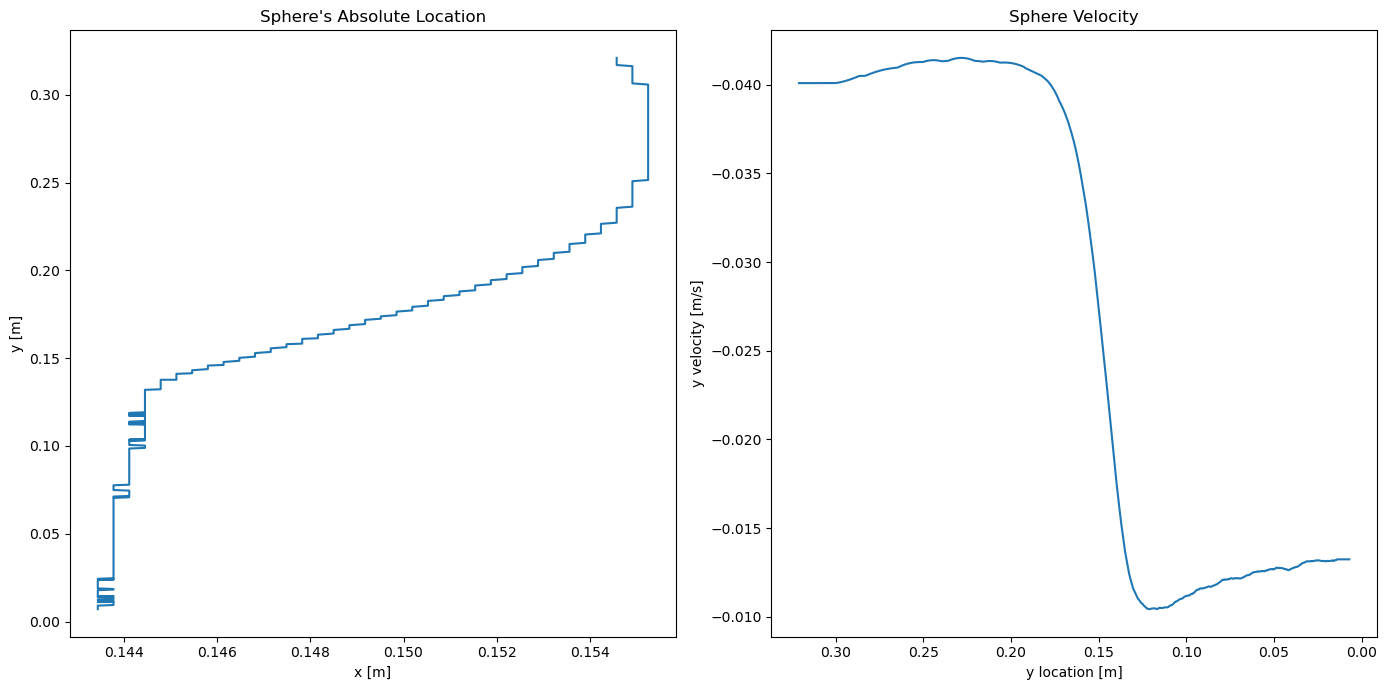

In [9]:
sphere_location_meter_PTV = np.array(sphere_location_meter_PTV)
velocitys_meter_PTV = np.array(velocitys_meter_PTV)
x_axis = sphere_location_meter_PTV[:, 0]
y_axis = sphere_location_meter_PTV[:, 1]
y_velocity = velocitys_meter_PTV

# Plot absolute location
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot absolute location
axs[0].set_title("Sphere's Absolute Location")
axs[0].plot(x_axis, y_axis)
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')

# Plot velocity (y axis only)
axs[1].set_title("Sphere Velocity")
axs[1].plot(y_axis, y_velocity)
axs[1].set_xlabel('y location [m]')
axs[1].set_ylabel('y velocity [m/s]')
axs[1].invert_xaxis()
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()


Creating a callable function of y location vs y velocity

לא יעבוד כאשר יש כדור קופץ כי הפונקציה היא לא חד חד ערכית

In [10]:
y_velocity_meter_func = Mf.create_callable_function_of_data(y_axis, y_velocity)

$\color{red}$ Now we will set the sphere location with respect to PIV rectangle origin bottom left corner

In [11]:
#make "sphere location" origin (0,0) same as PIV origin (0,0)
sphere_location_relative_to_piv=[]
for ind,el in enumerate(sphere_location_absolute):
    sphere_location_relative_to_piv.append([el[0]-PIV_origin_location[ind][0], el[1]-PIV_origin_location[ind][1]])

# in pixel
sphere_location_pixel = np.array(sphere_location_relative_to_piv)*scaling_factor

theortical density function. if the function is not measured

In [12]:
# interface_upper_location = Interface_height + Interface_thickness/2 #[m]
# interface_lower_location = Interface_height - Interface_thickness/2 #[m]
# amplitude = (lower_density-upper_density)/2
# middle_of_density = np.mean([upper_density, lower_density])
# interface_center = np.mean([interface_upper_location, interface_lower_location]) #[m]
# interface_width = interface_upper_location-interface_lower_location #[m]


# rho_function = Mf.density_function(amplitude = amplitude, interface_width = interface_width, center_of_interface = interface_center, mean_density_value = middle_of_density, plot = False)

# if True:
#     x_values = np.linspace(interface_center-interface_center*0.1, interface_center+0.1*interface_center, 1000)
#     y_values = rho_function(x_values)
#     plt.title('Density vs height graph')
#     plt.plot(y_values, x_values, '--', label='Density Function', color='red')
#     plt.xlabel(r'Density $ \left[ \frac {kg} {m^3} \right]$', rotation=0)
#     ylabel = plt.ylabel('Height [m]', rotation=0)
#     ylabel.set_verticalalignment('bottom')  # Align at the bottom of the label
#     ylabel.set_y(ylabel.get_position()[1] - 0)
#     plt.legend(fancybox=True, framealpha=0)
#     plt.show()

The measured density function

In [13]:
def find_average_density_location(y_locations, density_values):
    total_points = len(y_locations)

    # Calculate the overall average density
    overall_average_density = sum(density_values) / total_points

    # Calculate the absolute differences between each density value and the overall average
    differences = [abs(density - overall_average_density) for density in density_values]

    # Find the index of the minimum difference
    min_difference_index = differences.index(min(differences))

    # Return the corresponding y location
    return y_locations[min_difference_index]


In [14]:
def find_interface_thickness(x1, y1, show = False):
    x = x1[::-1]
    y = y1[::-1]

    # Normalize the density values between 0 and 1
    normalized_y = (y - min(y)) / (max(y) - min(y))



    # Find the points corresponding to the 1% and 99% thresholds
    threshold_1 = 0.02 
    threshold_2 = 0.98

    transition_point_1 = x[np.argmax(normalized_y <= threshold_1)]
    transition_point_2 = x[np.argmax(normalized_y >= threshold_2)]

    if show:
        # Plot the Density Function and CDF
        plt.plot(x, normalized_y, '--', label='Normalized Density Function', color='red')
        plt.axvline(x=transition_point_1, linestyle='--', color='green', label='Transition 2%')
        plt.axvline(x=transition_point_2, linestyle='--', color='orange', label='Transition 98%')
        plt.legend()
        plt.title('Normalized Density and Cumulative Density Functions')
        plt.show()

    return abs(transition_point_1 - transition_point_2)

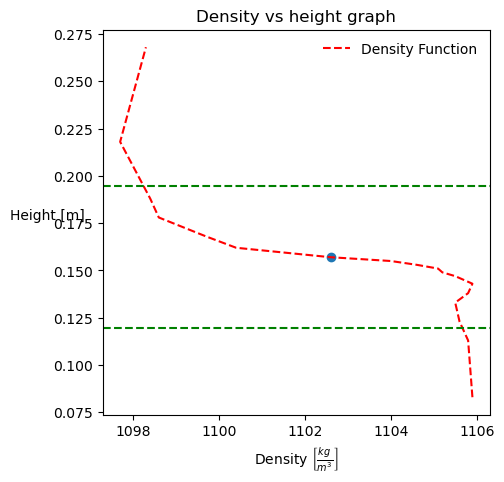

In [15]:
import My_functions as Mf
import numpy as np
# y_loccccc, densityccccc = Mf.load_density_profile_from_excel(date=Mf.convert_date(Mf.read_data_from_cihx(save_folder, '<date>')))
y_loccccc, densityccccc = Mf.load_density_profile_from_excel(date='2024 01 08')
y_loccccc2 = np.array(y_loccccc)
densityccccc2 = np.array(densityccccc)

rho_function = Mf.create_callable_function_of_data(y_loccccc, densityccccc)
inteface_center = find_average_density_location(y_loccccc2, densityccccc2)
interface_thickness = find_interface_thickness(y_loccccc2, densityccccc2)


import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(5,5))

plt.title('Density vs height graph')
plt.plot(densityccccc2, y_loccccc2, '--', label='Density Function', color='red')
plt.xlabel(r'Density $ \left[ \frac {kg} {m^3} \right]$', rotation=0)
ylabel = plt.ylabel('Height [m]', rotation=0)
plt.scatter(rho_function(inteface_center), inteface_center)

# Interface
plt.axhline(inteface_center-interface_thickness/2, linestyle='--', color='green')
plt.axhline(inteface_center+interface_thickness/2, linestyle='--', color='green')
plt.legend(fancybox=True, framealpha=0)
plt.show()

In [16]:
F_y = []
F_y_and_loc = []

txt_files_path = Mf.files_in_folder(save_folder_multy, 'txt', full_path = True)
txt_files_path_1 = []


for el in txt_files_path:
    if from_masked:
        if "masked" in el:
            txt_files_path_1.append(el)
    else:
        if not "masked" in el:
            txt_files_path_1.append(el)

txt_files_path = txt_files_path_1
txt_files_path_1 = 0

control volume will be as size of window? or a constant size? keep it as size of window for now

for win size we can just make the lengh very large and it will take the max and min values insterad of changing the script

In [17]:
control_volume_lengh = 3*sphere_diameter*100

The force acting on the water

<img title="Control Volume Integral" alt="Alt text" src="../Picture/IMG for markdown/control_vol_int.png">

we need to find the relevant place in Y for sum1 and sum2, and to cut the list for -2a<x<2a

In [18]:
# if show:
#     pictures_list = Mf.find_pictures(multy_cut_image_folder)
#     print("the red dot is the sphere's location With respect to the bottom left corner")

print(len(sphere_location_relative_to_piv))
for ind, el in enumerate(sphere_location_relative_to_piv):
    upper_location_rel = sphere_location_relative_to_piv[ind][1] + control_volume_lengh
    lower_location_rel = sphere_location_relative_to_piv[ind][1] - control_volume_lengh

    upper_location_absolute = sphere_location_absolute[ind][1] + control_volume_lengh
    lower_location_absolute = sphere_location_absolute[ind][1] - control_volume_lengh

    x, y, u, v = Mf.txt_to_column(txt_files_path[ind])

    start_y_upper, end_y_upper = Mf.find_closest_range_to_values_in_array(y, upper_location_rel) #return indexes
    start_y_lower, end_y_lower = Mf.find_closest_range_to_values_in_array(y, lower_location_rel) #return indexes

    start_x = Mf.find_closest_values_in_array(x, sphere_location_relative_to_piv[ind][0] - control_volume_lengh)
    end_x = Mf.find_closest_values_in_array(x, sphere_location_relative_to_piv[ind][0] + control_volume_lengh)
    v_upper = v[start_y_upper: end_y_upper][start_x: end_x] # [m/s]
    v_lower = v[start_y_lower: end_y_lower][start_x: end_x] # [m/s]

    if ind  == 1:
        print(v_upper, start_y_upper, end_y_upper, start_y_lower, end_y_lower, lower_location_rel)
    x_values = x[start_x: end_x] # [m]

    #note: sphere_velocity[ind][1] is the control volume velocity V_c
    w_squared_upper = (np.array(v_upper) - y_velocity_meter_func(sphere_location_absolute[ind][1]))**2 # [m^2 / s^2]
    w_squared_lower = (np.array(v_lower) - y_velocity_meter_func(sphere_location_absolute[ind][1]))**2 # [m^2 / s^2]
    
    #this is numeric integration, there is an uncertanty 
    sum_upper = scipy.integrate.trapz(w_squared_upper, x_values) # [m^3 / s^2]
    sum_lower = scipy.integrate.trapz(w_squared_lower, x_values) # [m^3 / s^2]


    # the force acting on the WATER:
    F_y_el = 4*sphere_diameter*(rho_function(upper_location_absolute)*sum_upper - rho_function(lower_location_absolute)*sum_lower) # [N]

##################
    # לקחת בחשבון הפרש לחצים בגלל הפרש גבהים במים?

    # צריך להפוך את הציר של מיקום הכדור ולעשות את שפת המים כ 0 כדי לקבל את הגובה
    #top of the tank is located at 0.6
    # #take in account the force due to pressure
    # top_of_tank = 0.6 #[m]
    # F_y_el  = F_y_el + 4*sphere_diameter**2*(((top_of_tank - sphere_location_absolute[ind][1]) + b)*rho_2*g - ((top_of_tank - sphere_location_absolute[ind][1])  - b)*rho_1*g)

##################

    # appending the force acting on the SPHERE not on the water:
    F_y.append(-F_y_el)
    F_y_and_loc.append([sphere_location_absolute[ind][1], -F_y_el])
    
    # if show:
    #     fig, ax = plt.subplots(figsize=(7,7))
    #     img = Mf.read_image(pictures_list[ind])
    #     imgy = np.copy(img)[::-1]
    #     # img.shape[0] => Y dimentions and img.shape[1] => X dimentions
    #     plt.imshow(imgy, cmap='gray', origin='lower', extent = (0, img.shape[1]/scaling_factor, 0, img.shape[0]/scaling_factor)) # make sure the origin is left bottom corner
    #     plt.scatter(sphere_location_relative_to_piv[ind][0], sphere_location_relative_to_piv[ind][1], s = 100, c = 'red')
    #     plt.title(os.path.basename(pictures_list[ind]))
    #     ax.set_xlabel('x [m]')
    #     ax.set_ylabel('y [m]')
    #     plt.show()

942
[ 2.6157070890979385e-04  5.9339812260448762e-04  3.6735885500968607e-04
 -8.9336970175557626e-04 -8.7869438332507615e-05  3.0472300763199336e-04
  3.5882173624019224e-04  3.6105697925146801e-04 -2.5910978236172071e-03
 -1.1570018643721010e-02 -7.9611779865430693e-03 -2.7068763378611652e-03
 -2.3587072404834268e-03 -1.4221425337113177e-03 -1.0605533270063240e-03
 -5.8347981723804202e-04 -1.1842277275647285e-03 -3.6895528274943695e-04] 0 18 190 208 -2.9571375


In [19]:
###CCCCCCCCCCCC
print(len(sphere_location_relative_to_piv))
for ind, el in enumerate(sphere_location_relative_to_piv):
    upper_location_rel = sphere_location_relative_to_piv[ind][1] + control_volume_lengh
    lower_location_rel = sphere_location_relative_to_piv[ind][1] - control_volume_lengh

    upper_location_absolute = sphere_location_absolute[ind][1] + control_volume_lengh
    lower_location_absolute = sphere_location_absolute[ind][1] - control_volume_lengh

    x, y, u, v = Mf.txt_to_column(txt_files_path[ind])

    start_y_upper, end_y_upper = Mf.find_closest_range_to_values_in_array(y, y[0]) #return indexes
    start_y_lower, end_y_lower = Mf.find_closest_range_to_values_in_array(y, y[-1]) #return indexes

    start_x = Mf.find_closest_values_in_array(x, sphere_location_relative_to_piv[ind][0] - control_volume_lengh)
    end_x = Mf.find_closest_values_in_array(x, sphere_location_relative_to_piv[ind][0] + control_volume_lengh)
    
    v_upper = v[start_y_upper: end_y_upper + 1][start_x: end_x + 1] # [m/s]
    v_lower = v[start_y_lower: end_y_lower + 1][start_x: end_x + 1] # [m/s]
    x_values = x[start_x: end_x + 1] # [m]

    if ind  == len(sphere_location_relative_to_piv)-1:
        print(v_upper, start_y_upper, end_y_upper, start_y_lower, end_y_lower, lower_location_rel, y[-1], y[0])

    #note: sphere_velocity[ind][1] is the control volume velocity V_c
    w_squared_upper = (np.array(v_upper) - y_velocity_meter_func(sphere_location_absolute[ind][1]))**2 # [m^2 / s^2]
    w_squared_lower = (np.array(v_lower) - y_velocity_meter_func(sphere_location_absolute[ind][1]))**2 # [m^2 / s^2]
    
    sum_upper = scipy.integrate.trapz(w_squared_upper, x_values) # [m^3 / s^2]
    sum_lower = scipy.integrate.trapz(w_squared_lower, x_values) # [m^3 / s^2]


    # the force acting on the WATER:
    F_y_el = 4*sphere_diameter*(rho_function(upper_location_absolute)*sum_upper - rho_function(lower_location_absolute)*sum_lower) # [N]


    # appending the force acting on the SPHERE not on the water:
    F_y.append(-F_y_el)
    F_y_and_loc.append([sphere_location_absolute[ind][1], -F_y_el])


942
[ 7.5645088714157589e-04  5.1001517354355350e-04  2.2652512939600912e-05
  7.7037285311711749e-04  2.6740673664047467e-04  9.9044637546032551e-05
  1.9825094072709608e-06 -1.0042110585348320e-04 -1.5548093604893776e-04
 -1.3791680346955994e-05 -1.1285325138272056e-03 -3.8367160111851763e-04
 -7.6487891730463360e-04  2.6129086917354630e-04  2.8959326462130403e-04
 -1.0367128983095855e-03 -1.1322272213211805e-04 -4.5242439383814763e-04
  1.4961523327490235e-06] 0 18 342 360 -2.9568 0.0054 0.10260000000000001


In [20]:
len(y), y[-1], y[0]

(361, 0.0054, 0.10260000000000001)

In [21]:
w_squared_upper,x_values, sum_upper

(array([0.001137677930983432, 0.001121114363795137, 0.001088715113472855,
        0.001138617286195801, 0.001104926683784053, 0.001093762169922958,
        0.001087351498943031, 0.00108060846430298 , 0.001076991575278564,
        0.001086311439535735, 0.001014072067416216, 0.001062066329225754,
        0.001037365043974882, 0.001104520132967561, 0.001106402155818515,
        0.001019928397425369, 0.001079766983115075, 0.001057589837264478,
        0.001087319423917619]),
 array([0.0054              , 0.0108              , 0.016200000000000003,
        0.0216              , 0.027000000000000003, 0.032400000000000005,
        0.03780000000000001 , 0.0432              , 0.048600000000000004,
        0.054000000000000006, 0.05940000000000001 , 0.06480000000000001 ,
        0.07020000000000001 , 0.07560000000000001 , 0.08100000000000002 ,
        0.0864              , 0.0918              , 0.09720000000000001 ,
        0.10260000000000001 ]),
 0.00010515208438740327)

Force from control volume is the dynamic force.

the bouyance force in present even if the flow field is zero and the water is stationary.

save files

In [22]:
save_file_name = 'Force_from_control_volume.pkl'
if from_masked:
    save_file_name = save_file_name[:-4] + '_Mask.pkl'

file_path = os.path.join(save_folder, save_file_name)
Mf.save_pickle(file_path, F_y)

The file Force_from_control_volume.pkl has been saved at: C:/Users/Morten/OneDrive - mail.tau.ac.il/Thesis/Python Thesis/Analysis/All outputs/compare/output run 3 regular


guessing_interface location

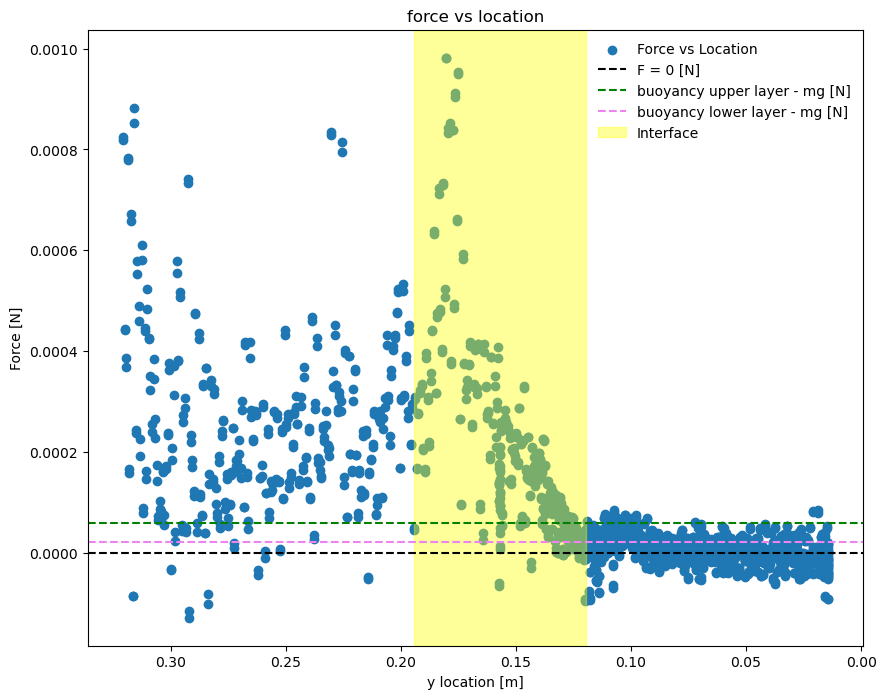

In [23]:
F_y_and_loc_np = np.array(F_y_and_loc)
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('force vs location')
ax.scatter(F_y_and_loc_np[:,0], F_y_and_loc_np[:,1], label='Force vs Location')

ax.axhline(y=0, color='black', linestyle='--', label='F = 0 [N]')
ax.axhline(y=-rho_function(0.6)*sphere_volume*g+mg, color='green', linestyle='--', label='buoyancy upper layer - mg [N]')
ax.axhline(y=-rho_function(0)*sphere_volume*g+mg, color='violet', linestyle='--', label='buoyancy lower layer - mg [N]')


# Define the coordinates and dimensions of the rectangle
rect_x = inteface_center-interface_thickness/2 #[m]
rect_width = interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range

# Create a Rectangle patch with transparency (alpha)
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)

ax.set_xlabel('y location [m]')
ax.set_ylabel('Force [N]')
ax.legend(fancybox=True, framealpha=0)
plt.gca().invert_xaxis()
plt.show()

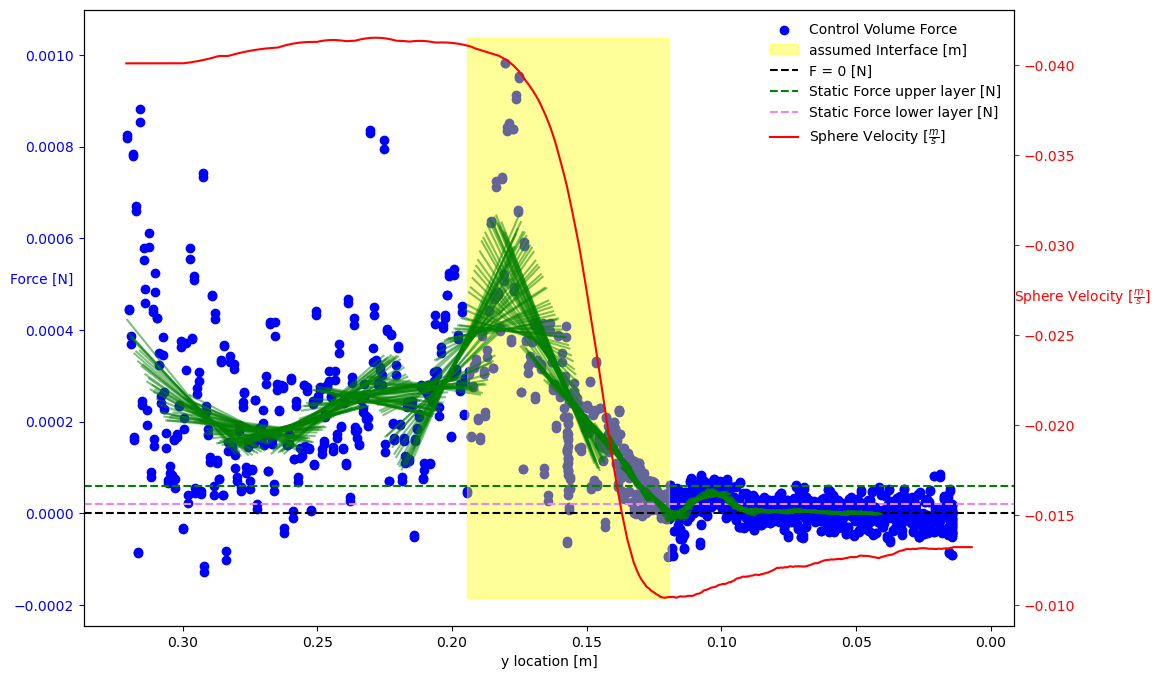

In [57]:
# Create a figure and left axis
fig, ax1 = plt.subplots(figsize=(12, 8))
# plt.title('Combined Graph')

# Plot the data for the left axis (Force vs Location)
ax1.scatter(F_y_and_loc_np[:, 0], F_y_and_loc_np[:, 1], label='Control Volume Force', color='blue')

# Define the coordinates and dimensions of the rectangle
rect_x = inteface_center-interface_thickness/2 #[m]
rect_width = interface_thickness
rect_y = ax1.get_ylim()[0]
rect_height = ax1.get_ylim()[1] - rect_y # Cover the entire y-axis range

# # Create a Rectangle patch with transparency (alpha)
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='assumed Interface [m]')
ax1.add_patch(rect_patch)

ax1.axhline(y=0, color='black', linestyle='--', label='F = 0 [N]')
ax1.axhline(y=-rho_function(0.6)*sphere_volume*g+mg, color='green', linestyle='--', label='Static Force upper layer [N]')
ax1.axhline(y=-rho_function(0)*sphere_volume*g+mg, color='violet', linestyle='--', label='Static Force lower layer [N]')

ax1.set_xlabel('y location [m]')
ax1.set_ylabel('Force [N]', color='blue', rotation=0, labelpad=-20, y=0.55)
ax1.tick_params('y', colors='blue')
# ax1.legend(loc='upper left', fancybox=True, framealpha=0)

# Create a twin axis for the right axis (Sphere Velocity)
ax2 = ax1.twinx()
ax2.plot(y_axis, y_velocity, color='red', label=r'Sphere Velocity $ \left[ \frac {m} {s} \right]$')
ax2.set_ylabel(r'Sphere Velocity $ \left[ \frac {m} {s} \right]$', color='red', rotation=0, labelpad=5, y=0.55)

ax2.tick_params('y', colors='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fancybox=True, framealpha=0)

# Invert x-axis
ax1.invert_xaxis()
ax2.invert_yaxis()


# save?
plt.savefig(os.path.join(save_folder, 'Combined Graph.svg'), transparent=True, bbox_inches='tight')
# plt.savefig(os.path.join(save_folder, 'Combined Graph.png'), transparent=True, bbox_inches='tight', dpi = 1000)
# plt.savefig(os.path.join(save_folder, 'Combined Graph.eps'), transparent=True, bbox_inches='tight')





the_number = 60
for i in range(len(F_y_and_loc_np) - the_number):
    if i<(len(F_y_and_loc_np) - the_number)*0.4:
        x_fit = F_y_and_loc_np[i:i+the_number+1, 0]
        y_fit = F_y_and_loc_np[i:i+the_number+1, 1]
        
        # Use np.polyfit to perform the least squares fit
        coefficients = np.polyfit(x_fit, y_fit, deg=1)
        
        # Create a smooth x-axis range for plotting the fitted curve
        x_smooth = np.linspace(x_fit.min(), x_fit.max(), 100)
        
        # Plot the fitted curve
        ax1.plot(x_smooth, np.polyval(coefficients, x_smooth), color='green', alpha=0.5)

plt.show()



Lets make a Cd graph
$ C_d = \frac{F}{\frac{1}{2}\rho U^2 \cdot S_p} $

where $S_p = \frac{\pi \cdot ({sphere\ diameter})^2} {4}$ is the projected surface area

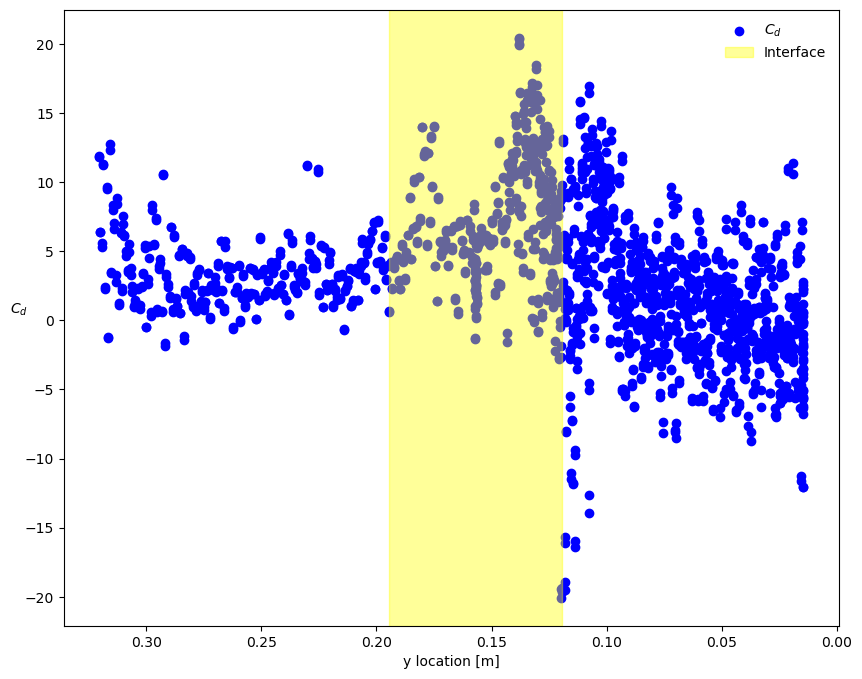

In [25]:
C_d_and_loc = np.copy(F_y_and_loc_np)
C_d_and_loc[:,1] = C_d_and_loc[:,1]/(0.5*(np.pi/4*sphere_diameter**2)*rho_function(C_d_and_loc[:,0])*y_velocity_meter_func(C_d_and_loc[:,0])**2)


fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(C_d_and_loc[:,0], C_d_and_loc[:,1], label=r'$C_d$', color = 'blue')

# Define the coordinates and dimensions of the rectangle
rect_x = inteface_center-interface_thickness/2 #[m]
rect_width = interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range

# Create a Rectangle patch with transparency (alpha)
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)

ax.set_xlabel('y location [m]')
ax.set_ylabel(r'$C_d$', rotation=0)
ax.legend(fancybox=True, framealpha=0)
plt.gca().invert_xaxis()
plt.savefig(os.path.join(save_folder, 'C_d.svg'), transparent=True, bbox_inches='tight')

plt.show()

הנקודה האדומה מציינת את מרכז הכדור, נראה שהיא לא בדיוק באמצע ויש כמה סיבות עיקריות

1) מיקום הנקודה האדומה זה אינטרפולציה לינארית בין 2 תמונות
2) האלגוריתם לא מוצא את המרכז בצורה מושלמת, בעיקר בשכבת המעבר כאשר יש שוני באינדקסי שבירה, הכדור מתעוות והאלגוריתם מוצא את מה שהכי קרוב
3) סביר מאוד שהמרכז לא נופל בפיקסל שלם, למשל הוא נמצא בפיקסלים (10.21, 10.68) ואי אפשר לייצג את זה כי חייב לבחור נקודה שתיהיה בפיקסל ספציפי ( במספר שלם) אז המחשב יציג לנו אותו ב (10,10)

optional show streamline.

need to be fixed

In [26]:
if False:
    pictures_list = Mf.find_pictures(multy_cut_image_folder)
    new_multy_cut_image_folder = os.path.join(multy_cut_image_folder, 'edited')
    Mf.create_directory(new_multy_cut_image_folder)
    for ind, el in enumerate(sphere_location_relative_to_piv):
        img = Mf.read_image(pictures_list[ind])
        Mf.save_stream_line_on_pic(txt_files_path[ind], save_path=os.path.join(new_multy_cut_image_folder, os.path.basename(pictures_list[ind])), scale=0.01, width = 0.003,scaling_factor=scaling_factor, on_img=True, image_name=pictures_list[ind])
        plt.close()
    Mf.display_images_with_points_napari(new_multy_cut_image_folder)